# Semantische Themen-Analyse mit LSI/LSA und LDA

## Vorbereitung: Abhängigkeiten installieren

In [29]:
import sys
import warnings
class StopExecution(Exception):
    def _render_traceback_(self):
        pass
from pprint import pprint
!{sys.executable} -m pip install -r ../requirements.txt
!{sys.executable} -m spacy download de_core_news_md
warnings.filterwarnings("ignore", category=DeprecationWarning)

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 21.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_md')


## Schritt 1: Aktuelle Daten herunterladen
Die Daten werden 1x pro Tag von `https://ordnungsamt.berlin.de/frontend.webservice.opendata/api/meldungen` heruntergeladen und im Ordner `../data` abgelegt. Alle folgenden Ausführungen am selben Tag werden exakt diese Daten verwenden.

In [83]:
from datetime import datetime
import os
import requests
import json
import pandas as pd

current_date = datetime.now().strftime("%Y-%m-%d")
dataset_path = f'../data/{current_date}.json'
base_model_folder = f'../models/{current_date}'

if os.path.exists(dataset_path):
    print("  Data already downloaded!")
else:    
    url = "https://ordnungsamt.berlin.de/frontend.webservice.opendata/api/meldungen"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        with open(dataset_path, 'w') as f:
            json.dump(data, f)
    else:
        print("  Error: Could not retrieve data from URL")

dataset = pd.read_json(dataset_path, orient='records', typ='series')
dataset = pd.DataFrame(map(lambda x: {'msg_id': x['id'], 'sachverhalt': x['sachverhalt']}, dataset['index']))

dataset.head()

  Data already downloaded!


,msg_id,sachverhalt
0,527563,Spiegel
1,527575,Holz-/Regalteile
2,622944,Pkw in geschützter Grünanlage aufgefahren
3,681533,None
4,788708,Bauschutt


## Schritt 2: Datensatz aufteilen und Texte vorverarbeiten
In diesem Schritt erstelle ich zuerst 2 verschiedene Datensätze (einen Trainings- und einen Test-Datensatz) mit einer 80/20-Verteilung. Das Test-Set wird am Ende des Notebooks zum Testen der Modelle verwendet.

Die Texte beider Datensätze werden danach wie folgt vorverarbeitet:
* Tokenisierung
* Entfernung von Stopwörtern, Punktuation und Zahlen
* Lemmatisierung
* PoS-Tagging (Part-of-Speech)

In [6]:
import spacy

nlp = spacy.load("de_core_news_md", disable=['ner', 'textcat', 'transformer', 'textcat_multilabel', 'entity_ruler', 'attribute_ruler'])

def tidy_tokens(docs):
    """Extract tokens and metadata from list of spaCy docs."""
    
    cols = [
        "msg_id", "token", "token_order", "lemma", 
        "ent_type", "tag", "dep", "pos", "is_stop", 
        "is_alpha", "is_digit", "is_punct"
    ]
    
    meta_df = []
    for ix, doc in enumerate(docs):
        meta = [
            (i.text, i.i, i.lemma_, i.ent_type_, i.tag_, 
            i.dep_, i.pos_, i.is_stop, i.is_alpha, 
            i.is_digit, i.is_punct) for i in doc if i.text.strip()
        ]
        meta = pd.DataFrame(meta)
        meta.columns = cols[1:]
        meta = meta.assign(msg_id = ix).loc[:, cols]
        meta_df.append(meta)
        
    return pd.concat(meta_df)

def run_text_pipeline(input_df: pd.DataFrame):
    docs = list(nlp.pipe(input_df.sachverhalt.astype(str)))
    df = tidy_tokens(docs)
    # remove short tokens and stopwords/punctuations/digits
    return df.loc[
        df.lemma.apply(lambda x: len(x) > 2) &
        ~df.is_stop & ~df.is_punct & ~df.is_digit
    ].groupby(['msg_id']).agg(lambda x: x.values.tolist()).lemma

# split into training and test set
train_data = dataset.sample(frac=0.8,random_state=200)
test_data = dataset.drop(train_data.index)

# cleanup sets
training_set = run_text_pipeline(train_data).values
test_set = run_text_pipeline(test_data).values

len(training_set), len(test_set)

(4718, 1184)

## Schritt 3: Textvektorisierung mit BoW und TF-IDF
In diesem Abschnitt vergleiche ich die zwei Textvektorisierungs-Methoden Bag-of-Words (BoW) und Term-Frequency Inverse-Document-Frequency (TF-IDF). Während Verben wie "sehen" oder "stehen" in einer reinen Wort-Frequenz-Zählung in den Top 5 rangieren, werden sie wegen ihrer generischen Natur von TF-IDF teilweise deutlich zurückgestuft.

### Variante 1: Bag-of-Words

In [11]:
from gensim import corpora
from collections import Counter

# create bag-of-words corpus
bow_dict = corpora.Dictionary()
bow_corpus = [bow_dict.doc2bow(doc, allow_update=True) for doc in training_set]

# get simple word frequency across corpus
def get_word_freq(corpus, dict):
    word_freq = Counter()
    for doc in corpus:
        for word, score in doc:
            word_freq[dict[word]] += score
    return word_freq

word_freq = get_word_freq(bow_corpus, bow_dict)
word_freq.most_common(10)


[('Müll', 412),
 ('stehen', 392),
 ('sehen', 387),
 ('Foto', 369),
 ('Gehweg', 343),
 ('liegen', 317),
 ('Sperrmüll', 221),
 ('Matratze', 189),
 ('Straße', 185),
 ('einkaufswagen', 185)]

### Variante 2: TF-IDF (Term-Frequency Inverse-Document-Frequency)

In [16]:
from gensim.models import TfidfModel

# create tf-idf model
tfidf_dict = corpora.Dictionary(training_set)
tfidf = TfidfModel(dictionary=tfidf_dict, smartirs='ntc')
tfidf_corpus = [tfidf[tfidf_dict.doc2bow(doc)] for doc in training_set]

# get overall tf-idf scores
word_freq = get_word_freq(tfidf_corpus, tfidf_dict)
word_freq.most_common(10)



[('Müll', 145.59552670878062),
 ('einkaufswagen', 145.06654738823778),
 ('Sperrmüll', 128.91832909039857),
 ('Foto', 116.3888672916541),
 ('Matratze', 113.29687973618073),
 ('sehen', 106.5416760854709),
 ('Gehweg', 83.71341832002379),
 ('Regelmeldung', 77.33964224755515),
 ('wöchentlich', 73.43160233210865),
 ('stehen', 71.90155282621254)]

## Schritt 4: Modell-Training
Nun werde ich 2 verschiedene Varianten für die Themen-Extraktion vergleichen: Latent Semanting Indexing/Analysis (LSA/LSI) und Latent Dirichlet Allocation (LDA). In einem ersten Schritt werde ich für verschiedene Anzahl Themen (`num_topcs`-Parameter für das `LsiModel` resp. `LdaMulticore`) den Koheränz-Score berechnen und auf einem Diagramm visualisieren. Dies soll mir erlauben, für das spätere Modell-Training die optimale Anzahl Themen zu wählen.

In [72]:
import gensim
import matplotlib.pyplot as plt
from gensim.models import LsiModel, LdaMulticore, CoherenceModel

# ---
# Diesen Code ausführen, enthält Hilfsfunktionen für beide Varianten!
# ---

def get_specific_topics(model, num_words=5):
    specific_topics = {}
    for topic_id in range(model.num_topics):
        if isinstance(model, gensim.models.LdaModel):
            terms = model.get_topic_terms(topic_id, num_words)
            specific_topics[topic_id] = [(model.id2word[term[0]], term[1]) for term in terms]
        else:
            terms = model.show_topic(topic_id, num_words)
            specific_topics[topic_id] = [(term[0], term[1]) for term in terms]
    return specific_topics

def compute_coherence_values(dict, corpus, model_type, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate model and store coherence score
        if model_type == 'lsi':
            model = LsiModel(corpus, num_topics=num_topics, id2word=dict)
        elif model_type == 'lda':
            model = LdaMulticore(corpus, num_topics=num_topics, id2word=dict, passes=10, workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=training_set, dictionary=dict, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# plot coherence scores to determine optimal topic count visually
def plot_graph(dict, corpus, model_type, start, stop, step):
    _, coherence_values = compute_coherence_values(dict, corpus, model_type, stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

### Variante 1: LSA-Modell trainieren
Zuerst werde ich versuchen, die optimale Anzahl Themenfelder anhand eines Diagramms zu eruieren.

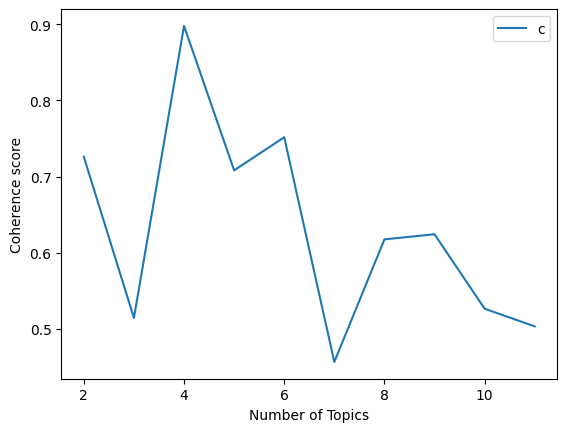

In [76]:
import gensim

lsa_dict = gensim.corpora.Dictionary(training_set)
lsa_corpus = [lsa_dict.doc2bow(doc) for doc in training_set]

start,stop,step = 2, 12, 1

plot_graph(lsa_dict, lsa_corpus, 'lsi', start, stop, step)

Das Diagram zeigt auf, dass die optimale Anzahl Themen zwischen 4 und 5 liegt, mit höheren Werten geht ein rapider Abfall des Coherence-Score einher.

In [80]:
num_topics = 4

lsi_model =  LsiModel(lsa_corpus, num_topics=num_topics, id2word=lsa_dict)
topics = get_specific_topics(lsi_model)

for topic_id, terms in topics.items():
    print(f"Topic {topic_id}:")
    for term, weight in terms:
        print(f"  {term}: {weight:.4f}")

# Compute Perplexity & Coherence Score
coherence_model_lsa = CoherenceModel(model=lsi_model, texts=training_set, dictionary=lsa_dict, coherence='c_v')
coherence_lsa = coherence_model_lsa.get_coherence()
print('Coherence Score: ', coherence_lsa)

Topic 0:
  Geräusch: -0.4971
  knallen: -0.4627
  aufeinander: -0.3370
  laut: -0.2376
  Topf: -0.2306
Topic 1:
  Foto: -0.4642
  sehen: -0.4142
  Gehweg: -0.3085
  liegen: -0.2938
  stehen: -0.2909
Topic 2:
  Gehweg: -0.4887
  Foto: 0.3314
  sehen: 0.2560
  Stelle: -0.1572
  direkt: -0.1418
Topic 3:
  Müll: -0.4106
  sehen: 0.3821
  stehen: 0.2622
  Haus: -0.2054
  Foto: 0.1825
Coherence Score:  0.5935278108827888


## Variante 2: LDA-Modell trainieren
Als zweite Variante trainiere ich mit den Daten ein LDA-Modell (Latent Dirichlet Allocation) zur Ermittlung der Top-Themen in den Daten. Auch hier soll in einem ersten Schritt die ideale Anzahl Themen anhand des Coherence-Scores ermittelt werden (dieses mal auf Basis des `LdaMulticore`-Modells).

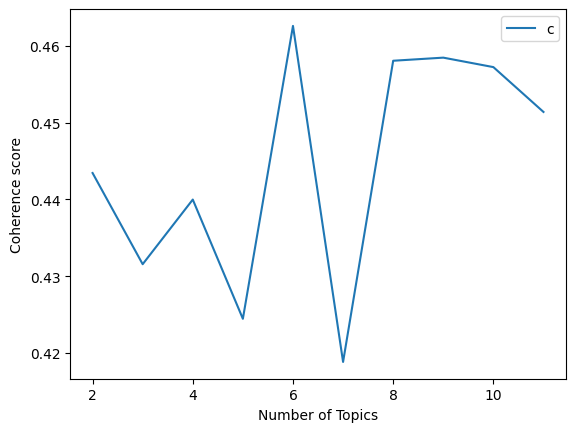

In [81]:

import gensim

lda_dict = gensim.corpora.Dictionary(training_set)
lda_corpus = [lda_dict.doc2bow(doc) for doc in training_set]

start,stop,step = 2, 12, 1

plot_graph(lda_dict, lda_corpus, 'lda', start, stop, step)

Bei LDA zeigt sich zum einen eine viel tiefere Varianz in der Koheränz undzum anderen ein allgemein tieferer Wert. Wir trainieren das LDA-Modell mit 8 Themenfeldern und visualisieren die Resultate mit dem Python-Paket `pyLDAvis`, zur Evaluation wird wieder der Coherence-Score herangezogen.

In [82]:
from gensim.models import CoherenceModel, LdaMulticore
import pyLDAvis.gensim_models

num_topics = 6

lda_model = LdaMulticore(lda_corpus, num_topics=num_topics, id2word=lda_dict, passes=10, workers=4)

# Compute Perplexity & Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=training_set, dictionary=lda_dict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Perplexity: ', lda_model.log_perplexity(lda_corpus))
print('Coherence Score: ', coherence_lda)

specific_topics = get_specific_topics(lda_model)
for topic_id, terms in specific_topics.items():
    print(f"Topic {topic_id}:")
    for term, weight in terms:
        print(f"  {term}: {weight:.4f}")

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(
    lda_model,
    lda_corpus,
    lda_dict,
    sort_topics=False
)
pyLDAvis.display(vis)


Perplexity:  -8.254185687401753
Coherence Score:  0.4455326057132476
Topic 0:
  Müll: 0.0429
  Regelmeldung: 0.0205
  wöchentlich: 0.0187
  Reifen: 0.0101
  Gehweg: 0.0066
Topic 1:
  Sperrmüll: 0.0444
  einkaufswagen: 0.0411
  Sofa: 0.0151
  Müll: 0.0091
  Sessel: 0.0081
Topic 2:
  Matratze: 0.0308
  Müllablagerung: 0.0137
  stehen: 0.0125
  Straße: 0.0089
  Couch: 0.0088
Topic 3:
  Foto: 0.0484
  sehen: 0.0479
  stehen: 0.0258
  liegen: 0.0152
  Baum: 0.0139
Topic 4:
  Gehweg: 0.0263
  liegen: 0.0237
  parken: 0.0144
  Kühlschrank: 0.0116
  Fahrzeug: 0.0101
Topic 5:
  Stuhl: 0.0173
  Woche: 0.0147
  Tisch: 0.0127
  stehen: 0.0120
  Gehweg: 0.0111
